1 -- meta data for the document
2 -- sets up for R parralel computing commented out stuff changes size and muber of cores
3 -- visualises colour palets seems asthetit
4 -- if a chuck has not been changed it stays run
5 -- seurat basis of SCA and tidyvers plots
6 -- brings in dataframes and skips first seven rows. 
7 -- checks column names 
9 -- data is transposed so genes become columns and sells become rows
10 -- sparse matrices from dense matrixis
11 -- creates suerat dataframe for each dataset, 
12 -- add metadata of tags to each dataset
13 -- log normalises the data to account for sequencing depth (HVGs are selected)
14 -- selects features for integration and gets anchors
15 -- integrates data and removes batch effects. 
16 -- adds metadata for rna assay, finalises datastructure to be comp with suerat pipeline
17/18 QC metrics like mitocondrial data added to dataset
19 visualise mt data
20 filter mt < 25 and >500 RNA 
21 visualise filtering
22 scatterplots
23 scales data to a z scoer required for pcs, dimensional requctionPCA umap and clustering then visualisation 
24 25 visualises pcs with dimn plot, elpow plot plot shows importance of diffferent dimensions
26 shows how cells from diffent smamples are distributed in the dimension space, and hughlights clusters to identify cell groupings. 
27 splitting umap by sample seeing how different samples map into the different dimensions. 
28 sets the defalt assay, the active assay uses raw rna expression data and marks genes, only pos focus only on high value 
29 we save the marker genes to a new file, these results are computationally intest to generate so its handy to save them for later. 
30 normlising the expression of each gene, prepares the data for downstream analysis
31 heat map of top marker genese, markers are grouped by cluster colume. 
32 loading singler and celldex libraries
33 bring in reference mouse datasets
34 suerat object is made to single cell and reduced in size 
35 comparing the sce and red datasets, and annotates predicted cell types for each cell in dataset. 
36
37 dimplots to see the different cell types in the differnc dimensoin clusters. 
38 adding single R annotations adding predcted cell type data
39splits map into diffent samples 
40 find markers for each sample with idents, and identifies marker genes for each sample. only focuses on outlier expression genes
41 inspects sample markers dataframe
42 violin plot for marker genes. using RNA data. and combines the plots froam all the different samples, 
43 feature plot for expression of specified gene over samples. 
44 feature plot for an expression pattern of CfH
45 things are saved




In [78]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix, issparse
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap import UMAP
from anndata import AnnData
import scanpy as sc
import os
import igraph
import leidenalg


In [65]:
#seems the first seven rows is header data of no use to the analysis, is this common practice? 
data_paths = [
    "../WTA1/WTA-Pipeline-Brain-slices_RSEC_MolsPerCell.csv",
    "../WTA2/_1_WTA-Pipeline-Brain-slices_RSEC_MolsPerCell.csv",
    "../WTA3/_3_WTA-Pipeline-Brain-slices_RSEC_MolsPerCell.csv",
    "../WTA4/_2_WTA-Pipeline-Brain-slices_RSEC_MolsPerCell.csv"
]

# Load datasets into a list of DataFrames
df_list = []
for i, path in enumerate(data_paths):
    df = pd.read_csv(path, skiprows=7, index_col=0)  # Skip the first 7 rows
    df_list.append(df)

# Print a summary of the loaded DataFrames
for i, df in enumerate(df_list):
    print(f"Dataset {i + 1}: {df.shape} rows x columns")
    print(df.head())

Dataset 1: (4051, 27600) rows x columns
            0610005C13Rik  0610006L08Rik  0610009B22Rik  0610010F05Rik  \
Cell_Index                                                               
9010655                 0              0              7             19   
7253435                 0              0             16             10   
1964                    0              0              9             20   
9296317                 0              0             13             36   
1339426                 0              0              4             10   

            0610010K14Rik  0610012D04Rik  0610012G03Rik  0610025J13Rik  \
Cell_Index                                                               
9010655                 0              0             21              0   
7253435                 0              0              5              0   
1964                    0              0             18              0   
9296317                 0              0             22              0 

In [66]:
adata_list = []
for i, df in enumerate(df_list):
    # Ensure gene names (columns) are strings
    df.columns = df.columns.astype(str)
    # Create AnnData object without transposing
    adata = AnnData(X=df.values, obs=pd.DataFrame(index=df.index), var=pd.DataFrame(index=df.columns))
    # Add sample metadata
    adata.obs['sample'] = f"WTA{i+1}"
    # Ensure unique observation names
    adata.obs_names_make_unique()
    adata_list.append(adata)

print(f"Successfully converted {len(adata_list)} datasets to AnnData.")



Successfully converted 4 datasets to AnnData.


/Users/conorisco/Library/CloudStorage/OneDrive-TrinityCollegeDublin/TCD Omics/Runs/RCSI/data and analysis/Python_pipeline/Leo_Phelan_Project/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/conorisco/Library/CloudStorage/OneDrive-TrinityCollegeDublin/TCD Omics/Runs/RCSI/data and analysis/Python_pipeline/Leo_Phelan_Project/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/conorisco/Library/CloudStorage/OneDrive-TrinityCollegeDublin/TCD Omics/Runs/RCSI/data and analysis/Python_pipeline/Leo_Phelan_Project/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/

In [67]:
for adata in adata_list:
    adata.var_names = adata.var_names.str.upper().str.strip()  # Convert to uppercase and remove whitespace


for i, adata in enumerate(adata_list):
    print(f"AnnData {i + 1} shape: {adata.shape}")
    print("Observation names (cells):", adata.obs_names[:5])
    print("Variable names (genes):", adata.var_names[:5])



AnnData 1 shape: (4051, 27600)
Observation names (cells): Index(['9010655', '7253435', '1964', '9296317', '1339426'], dtype='object', name='Cell_Index')
Variable names (genes): Index(['0610005C13RIK', '0610006L08RIK', '0610009B22RIK', '0610010F05RIK',
       '0610010K14RIK'],
      dtype='object')
AnnData 2 shape: (6880, 27844)
Observation names (cells): Index(['1198119', '1211996', '9733664', '7534081', '5621771'], dtype='object', name='Cell_Index')
Variable names (genes): Index(['0610005C13RIK', '0610006L08RIK', '0610009B22RIK', '0610010F05RIK',
       '0610010K14RIK'],
      dtype='object')
AnnData 3 shape: (5658, 28103)
Observation names (cells): Index(['14012255', '614047', '760785', '1183572', '10358409'], dtype='object', name='Cell_Index')
Variable names (genes): Index(['0610005C13RIK', '0610006L08RIK', '0610009B22RIK', '0610010F05RIK',
       '0610010K14RIK'],
      dtype='object')
AnnData 4 shape: (4309, 27362)
Observation names (cells): Index(['10490172', '1183558', '9307022'

In [68]:
adata_combined = ad.concat(
    adata_list, 
    merge="same",  # Keep only shared genes
    label="sample", 
    keys=[f"WTA{i+1}" for i in range(len(adata_list))]
)

print(f"Combined AnnData shape: {adata_combined.shape}")


Combined AnnData shape: (20898, 26231)


/Users/conorisco/Library/CloudStorage/OneDrive-TrinityCollegeDublin/TCD Omics/Runs/RCSI/data and analysis/Python_pipeline/Leo_Phelan_Project/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [69]:
print(f"Combined AnnData shape: {adata_combined.shape}")
print("Observation names (cells):", adata_combined.obs_names[:5])
print("Variable names (genes):", adata_combined.var_names[:5])


Combined AnnData shape: (20898, 26231)
Observation names (cells): Index(['9010655', '7253435', '1964', '9296317', '1339426'], dtype='object', name='Cell_Index')
Variable names (genes): Index(['0610005C13RIK', '0610006L08RIK', '0610009B22RIK', '0610010F05RIK',
       '0610010K14RIK'],
      dtype='object')


In [70]:
# Normalize counts per cell and log-transform
sc.pp.normalize_total(adata_combined, target_sum=1e4)  # Normalize total counts
sc.pp.log1p(adata_combined)  # Log-transform the data
print("Data normalized and log-transformed.")
sc.pp.highly_variable_genes(adata_combined, flavor='seurat', n_top_genes=2000)
print(f"Number of highly variable genes: {sum(adata_combined.var['highly_variable'])}")


Data normalized and log-transformed.
Number of highly variable genes: 2000


In [71]:
# Scale the data and run PCA
sc.pp.scale(adata_combined, max_value=10)  # Standardize the data
sc.tl.pca(adata_combined, n_comps=50)  # Run PCA
print("PCA complete.")

# Compute neighborhood graph and run UMAP
sc.pp.neighbors(adata_combined, n_neighbors=10, n_pcs=30)  # Build the graph
sc.tl.umap(adata_combined)  # Run UMAP
print("UMAP embedding complete.")


PCA complete.
UMAP embedding complete.


In [72]:
sc.tl.leiden(adata_combined, resolution=0.5)  # Run Leiden clustering
print("Clustering complete.")


Clustering complete.


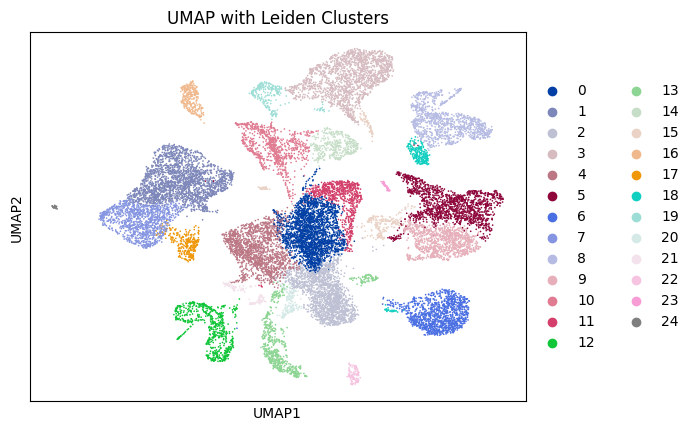

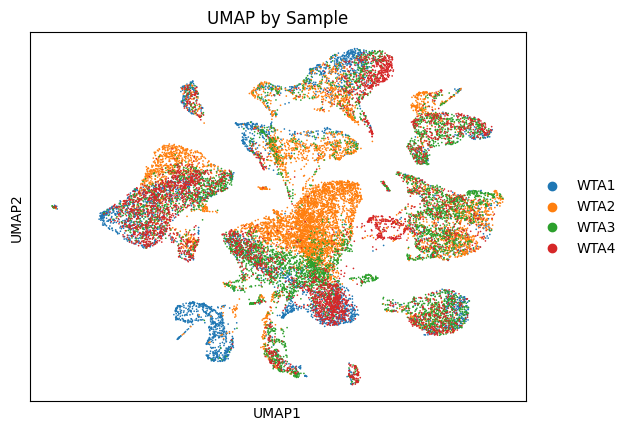

In [73]:
# UMAP plot colored by clusters
sc.pl.umap(adata_combined, color='leiden', title="UMAP with Leiden Clusters")
# UMAP plot colored by sample labels
sc.pl.umap(adata_combined, color='sample', title="UMAP by Sample")

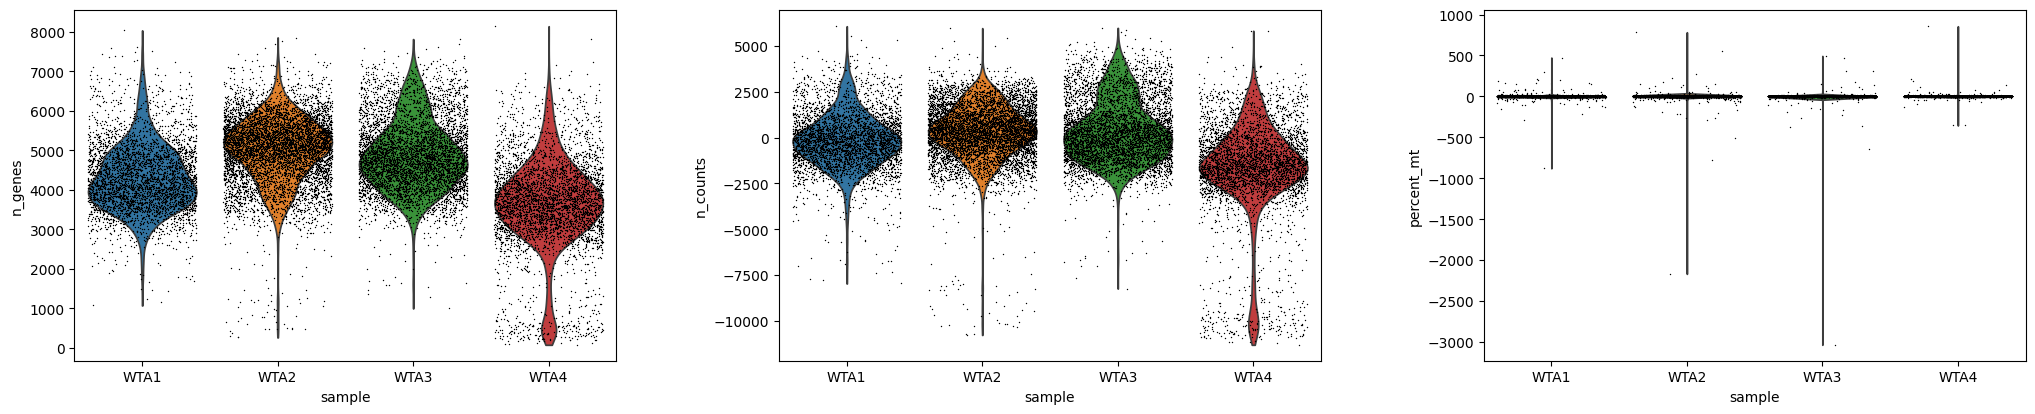

In [74]:
# Calculate mitochondrial gene percentage
adata_combined.var['mt'] = adata_combined.var_names.str.startswith('MT-')
adata_combined.obs['percent_mt'] = (
    adata_combined[:, adata_combined.var['mt']].X.sum(axis=1) /
    adata_combined.X.sum(axis=1)
) * 100

# Calculate the number of detected genes per cell
adata_combined.obs['n_genes'] = (adata_combined.X > 0).sum(axis=1)

# Calculate the total counts per cell
adata_combined.obs['n_counts'] = adata_combined.X.sum(axis=1)

# Visualize quality metrics
sc.pl.violin(adata_combined, ['n_genes', 'n_counts', 'percent_mt'], jitter=0.4, groupby='sample')


In [75]:
# Apply filters, can we improve this add add a QC report?
adata_filtered = adata_combined[
    (adata_combined.obs['percent_mt'] < 25) &
    (adata_combined.obs['n_genes'] > 500) &
    (adata_combined.obs['n_genes'] < 7500) &
    (adata_combined.obs['n_counts'] < 50000)
].copy()

print(f"Filtered dataset shape: {adata_filtered.shape}")

Filtered dataset shape: (20636, 26231)


/Users/conorisco/Library/CloudStorage/OneDrive-TrinityCollegeDublin/TCD Omics/Runs/RCSI/data and analysis/Python_pipeline/Leo_Phelan_Project/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [76]:
# Check for NaN values in the expression matrix
print(f"Any NaN in data matrix: {np.isnan(adata_filtered.X).any()}")

# Check for NaN values in `obs` or `var`
print(f"Any NaN in obs: {adata_filtered.obs.isna().any().any()}")
print(f"Any NaN in var: {adata_filtered.var.isna().any().any()}")



Any NaN in data matrix: False
Any NaN in obs: False
Any NaN in var: True


In [77]:
# Check for NaN in sparse matrix
if issparse(adata_filtered.X):
    # Convert to dense and check for NaN
    if np.isnan(adata_filtered.X.toarray()).any():
        print("NaN values found in the sparse data matrix. Handling them now.")
        # Replace NaN values with zeros and convert back to sparse
        adata_filtered.X = csr_matrix(np.nan_to_num(adata_filtered.X.toarray()))
else:
    # Directly check and replace NaN in dense matrix
    if np.isnan(adata_filtered.X).any():
        print("NaN values found in the dense data matrix. Handling them now.")
        adata_filtered.X = np.nan_to_num(adata_filtered.X)

print("NaN values handled successfully.")

NaN values handled successfully.


In [79]:
# Identify highly variable genes using the Seurat method
sc.pp.highly_variable_genes(
    adata_filtered,
    flavor='seurat',
    n_top_genes=2000  # Adjust this as needed
)

# Check the number of HVGs identified
print(f"Number of highly variable genes: {adata_filtered.var['highly_variable'].sum()}")


Number of highly variable genes: 2000


Number of genes before filtering: 2000
Number of highly variable genes: 2000
Scaling data...


/Users/conorisco/Library/CloudStorage/OneDrive-TrinityCollegeDublin/TCD Omics/Runs/RCSI/data and analysis/Python_pipeline/Leo_Phelan_Project/lib/python3.11/site-packages/scanpy/preprocessing/_scale.py:318: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/conorisco/Library/CloudStorage/OneDrive-TrinityCollegeDublin/TCD Omics/Runs/RCSI/data and analysis/Python_pipeline/Leo_Phelan_Project/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


Data scaling complete.
Running PCA...
PCA complete.
Explained Variance Ratio (First 10 Components): [0.0276759  0.01751291 0.01513782 0.01097425 0.00881123 0.00724414
 0.0061995  0.00469253 0.00432634 0.00430681]
Total Explained Variance (First 50 Components): 0.16739279
Plotting PCA Variance Ratio...


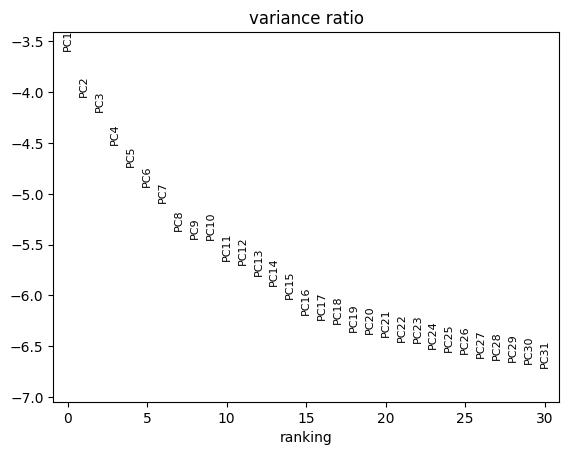

Plotting PCA components...


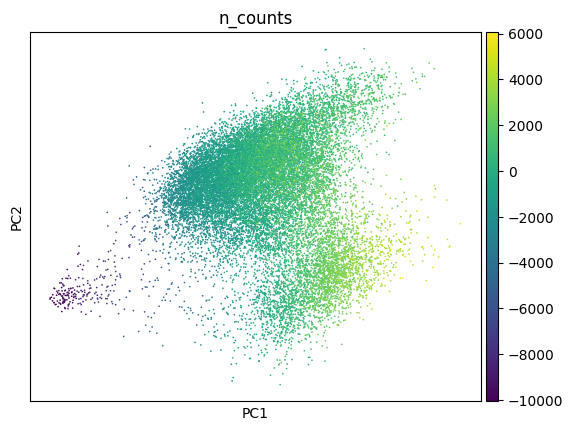

PCA Loadings (First 5 genes):
[[ 4.00925241e-03 -1.08938070e-03  1.86960294e-03  5.73171256e-03
  -8.60993459e-04 -1.27186405e-03  1.94027834e-03  2.75250903e-04
  -1.15794688e-03 -5.08754095e-03 -1.37423910e-03  4.35972679e-03
   1.80357369e-04  3.66618368e-03 -4.83070442e-04  1.99109619e-03
  -8.39738641e-04 -9.56331030e-04  6.60452526e-03  5.81933698e-03
  -8.66494048e-03  9.40006133e-03  2.60228035e-03  2.16253349e-04
   1.64416817e-03  2.76744831e-03 -1.74092443e-03  2.12169392e-03
  -1.66959446e-02  5.26863756e-03  6.31280150e-03  1.86788573e-04
   6.64305966e-03 -1.02186641e-02  6.75972225e-03 -2.15077586e-03
  -3.09922197e-03  6.89270766e-03 -1.11450593e-03  5.37236978e-04
  -8.42425972e-03 -1.52279222e-02  2.38733762e-03  2.07012473e-03
  -3.79123935e-03  4.71355539e-04 -9.01074987e-03  1.84939930e-03
   7.02775177e-03  1.27087804e-02]
 [ 2.55349595e-02  3.30079421e-02 -2.49268278e-03 -1.13105932e-02
  -7.80152949e-03  1.50881009e-03 -1.49384597e-02  2.62859575e-02
   4.100329

AssertionError: Explained variance does not sum to 1.

In [83]:
# Subset the dataset to include only highly variable genes
print(f"Number of genes before filtering: {adata_filtered.n_vars}")
adata_filtered = adata_filtered[:, adata_filtered.var['highly_variable']]
print(f"Number of highly variable genes: {adata_filtered.n_vars}")

# Scale the data to zero mean and unit variance
print("Scaling data...")
sc.pp.scale(adata_filtered, max_value=10)  # Prevent extreme values from dominating
print("Data scaling complete.")

# Perform PCA
print("Running PCA...")
sc.tl.pca(adata_filtered, n_comps=50)  # Adjust n_comps if needed
print("PCA complete.")

# Extract and print explained variance ratio
explained_variance_ratio = adata_filtered.uns['pca']['variance_ratio']
print("Explained Variance Ratio (First 10 Components):", explained_variance_ratio[:10])
print("Total Explained Variance (First 50 Components):", explained_variance_ratio.sum())

# Visualize PCA variance ratio as a scree plot
print("Plotting PCA Variance Ratio...")
sc.pl.pca_variance_ratio(adata_filtered, log=True)  # Scree plot without custom title

# Optional: Visualize PCA components
print("Plotting PCA components...")
sc.pl.pca(adata_filtered, color='n_counts', components=['1,2'])

# Print detailed PCA results
print("PCA Loadings (First 5 genes):")
print(adata_filtered.varm['PCs'][:5])

# Verify the variance ratio sums up correctly
assert np.isclose(explained_variance_ratio.sum(), 1.0, atol=1e-3), "Explained variance does not sum to 1."

print("PCA Analysis Complete.")


Neighborhood graph computed.
UMAP embedding complete.


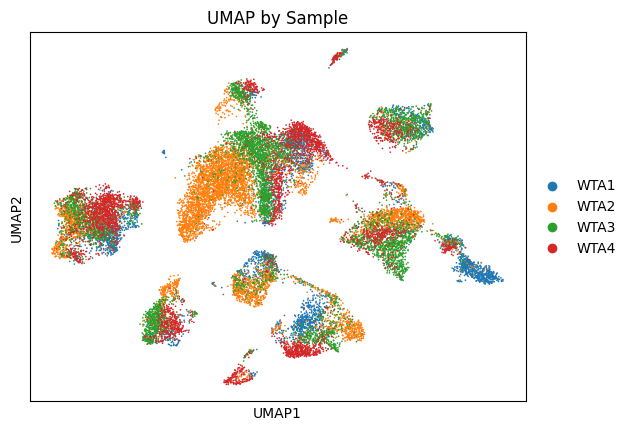

In [81]:
# Compute the neighborhood graph
sc.pp.neighbors(adata_filtered, n_neighbors=10, n_pcs=30)  # Adjust n_neighbors and n_pcs as needed
print("Neighborhood graph computed.")

# Run UMAP for visualization
sc.tl.umap(adata_filtered)
print("UMAP embedding complete.")

# Visualize the UMAP embedding
sc.pl.umap(adata_filtered, color=['sample'], title='UMAP by Sample')
